In this notebook we will apply what we have learned in prevous one (motion-tracking.ipynb where we developed necessary code for rectangular pattern of circles) and try to adjust our code for circular pattern and diffferent conditions (illumination, objects, ...)

To achieve this we need to:
1. Correct lens distortion by doing camera calibration (can also try to find exisitng params)
2. Load the video and select representative frame
3. Find objects we will use for obtaining transformation parameters
 *  4 holes that should lie in the corners of a square
 *  Trapezoid defined by major and minor axes of an ellipse as compared to sqare circumscribed to idealized circle
4. Use 2-step approach for getting view from top (Perspective + Affine)
5. Get scale from radius in the image as compared to real world radius

In [1]:
# Import packages
from scipy.spatial import distance as dist
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from skimage import exposure
import sys
%matplotlib inline

### Camera Calibration
We will use some coefficients found online. Eventually we should just capture some images for given resolution on our own.


In [65]:
# The following params were found online for 1920x1080 GOPro video.
# https://www.theeminentcodfish.com/gopro-calibration/
intrinsic_matrix = np.array([[857.48296979, 0, 968.06224829],
                   [0, 876.71824265, 556.37145899],
                   [0, 0, 1]], dtype = np.float32)
distortion_coeffs = np.array([[-2.57614020e-01, 8.77086999e-02, -2.56970803e-04, -5.93390389e-04, -1.52194091e-02]], dtype = np.float32)
# We also have 2704x1520 videos -.-. No available calibration found, but it is the same aspect ratio as 1920x1080 so it may work for both cases.

### Getting video frame for calculation of projection matrix

In [3]:
# Get video:
# video_src = "videos/seagull.MP4" # for debugging, works nicely

# GoPro . MP4 Videos require specific codec -.-
# https://github.com/adaptlearning/adapt_authoring/wiki/Installing-FFmpeg
# Unfortunately it still doesnt work!!

# White table, fits in the frame
# video_src = "//DCPHARMAIN/RawDataEIN/Ladina/Behaviour/Barnes maze/Cx30u43 cKO/cohort1u2/9mth/day4/GOPR0982.MP4"
# video_src = "videos/GOPR0950.MP4"
video_src = "videos/test.avi" # this is GOPR0950.MP4 converted with ffmpeg -.-

# Brown table, almost fits
#video_src = "//DCPHARMAIN/RawDataEIN/Ladina/Behaviour/Barnes maze/Cx30u43 cKO/cohort1u2/2mth/2mth-testday9/Clip181.m4v" 

In [68]:
def resize_frame(image):
    # Read Image and force size. Save scaling ratio
    hght = 500
    ratio = image.shape[0] / hght
    image = imutils.resize(image, height = hght)
    return image, ration

def fit_undistort(frame, mtx, dist, refit = False):
    '''
    Eventually this function will apply undistortion for our specific camera. Currently it doesn't do any good.
    '''   
    if refit:
        # you may want to refit the intrinsic matrix
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#undistortion
        
        h, w = frame.shape[:2]
        mtx_new, roi_crop = cv2.getOptimalNewCameraMatrix(mtx, dist, imageSize = (w,h), alpha = 1, newImgSize = (w,h))
        # undistort using the new found matrix
        dst = cv2.undistort(frame, mtx, dist, dst = None, newCameraMatrix = mtx_new)
        # Crop empty pixels
        x,y,w,h = roi_crop
        dst = dst[y:y+h, x:x+w]
        
    else:
        # Just apply undistortion with unchanged params
        dst = cv2.undistort(frame, mtx, dist)
        
    return dst

def order_points(pts, ratio = 1):
    '''
    Function to put points of bounding box in clockwise order
    '''
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="int32") * ratio


def selectROI(img, win_name, undistort = False):
    print("SelectROI (Enter=confirm, Esc=exit)")
    # Prompt for ROI to be analyzed
    try:
        # from IPython.core.debugger import set_trace; set_trace()
        if undistort: # currently it doesn't help at all
            img = fit_undistort(img, intrinsic_matrix, distortion_coeffs)
        
        (c, r, w, h) = cv2.selectROI(win_name, img, fromCenter = False, showCrosshair = False)
        # Esc kills the window
        if cv2.waitKey(0) & 0xff == 27:
            cv2.destroyAllWindows()
    finally:
        cv2.destroyAllWindows()
    # Store bounding box corners    
    pts = [[r, c], [r, c+w], [r+h, c], [r+h, c+w]]
    pts = order_points(np.asarray(pts))
    # Pull out roi
    roi = img[r:r+h, c: c+w]
    return pts, roi


def getGoodROI(video_src, release = False):
    # Prompt user to select a good frame we will work on later
    print ("Press key `p` to pause the video and select ROI")
    # Capture video
    vid = cv2.VideoCapture(video_src)
    count = 0
    try:
        while vid.isOpened():
            
            
#             print(vid.get(cv2.CAP_PROP_POS_FRAMES)) # debug
#             # print(vid.get(cv2.CAP_PROP_FOURCC)) # debug
#             count += 1
#             if count == 17:
#                 # One-liner to start the debugger here.
#                 from IPython.core.debugger import set_trace; set_trace()
            
            # Read next frame
            retval, frame = vid.read()
            # Exit when video cant be read
            if not retval: print ('Cannot read video file'); sys.exit();
            # Pause on 'p'
            if(cv2.waitKey(10) == ord('p')):
                #Define an initial bounding box
                # bbox = (158, 26, 161, 163)
                # Uncomment the line below to select a different bounding box
                pts, roi = selectROI(frame, win_name = "SelectROI")
                break # Break from while loop

            # Show the current frame
            cv2.namedWindow("SelectROI", cv2.WINDOW_NORMAL)
            cv2.imshow("SelectROI", frame)
    finally:
        # Assure all windows closed
        cv2.destroyAllWindows()
        
    # Get posiiton in videos in frames
    frame_pos = vid.get(cv2.CAP_PROP_POS_FRAMES)
    # Optionally release video object
    if release: vid.release();
        
    return pts, roi, vid, frame_pos

def goToFrame(vid, frame_pos, video_source):
    if not vid:
        vid = cv2.VideoCapture(video_source)  
    # Later may add a check if video is already opened
    vid.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
    return vid

In [72]:
changeFlag = False
if changeFlag:
    pts, roi, vid, frame_pos = getGoodROI(video_src)
else:
    frame_pos = 194.0
    pts = np.array([[158.0, 405.0],
                   [1520.0, 405.0],
                   [1520.0, 2389.0],
                   [158.0, 2389.0]], dtype= np.int32)
    vid = goToFrame([], frame_pos, video_source = video_src)
    _, frame = vid.read()
    roi = frame[pts[0][0]:pts[1][0], pts[0][1]:pts[2][1],:]

# Projective + Affine Transform
In this code we first apply projective transform to get a rectangular roi from the image. We than apply affine transform to get final estimate of the undistored shape.
## Projective Transform

In [155]:
# If necessary, can also skeletonize
def skeletonize(edged):
    size = np.size(edged)
    img = edged.copy()
    done = False
    skel = np.zeros(img.shape,np.uint8)

    while not done:
        eroded = cv2.erode(img, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True
    
    return skel

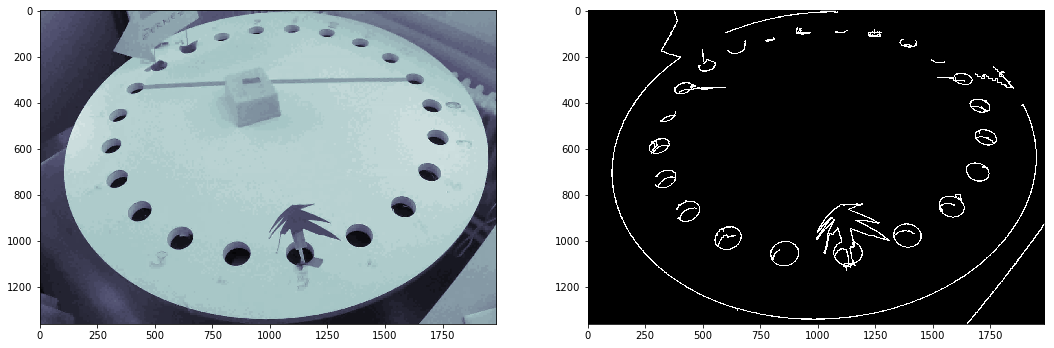

In [162]:
# convert it to grayscale, and blur it slightly
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
gray_sharp = gray.copy()
# Note that sigma and ksize are scale dependent!!! 
gray = cv2.GaussianBlur(gray, ksize = (3, 3), sigmaX = 0)
#gray = cv2.bilateralFilter(gray, d = 11, sigmaColor = 17, sigmaSpace = 17)
# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
edged = cv2.Canny(gray, threshold1 = 0, threshold2 = 255)
edged = cv2.dilate(edged, kernel = kernel, iterations=1)
# edged = cv2.erode(edged, kernel = None, iterations=1)

# Visualize the result
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 18))
ax1.imshow(gray, cmap = 'bone')
ax2.imshow(edged, cmap = 'bone')
plt.show()

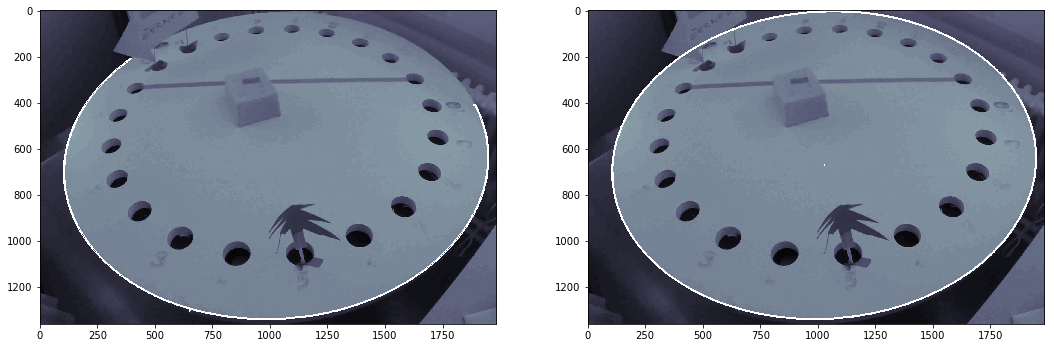

In [170]:
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] # Pick second element of list, dunno really what other hold
 
# sort the contours from left-to-right and initialize the bounding box
# point colors
#(cnts, _) = sort_contours(cnts) # Sort contour by the size of the bbox in decreasing order
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10] # This should also work
colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))

cntMax = cnts[1] # get biggest contour from top of the sorted stack
cntMax = cntMax[170:-170] # Keep only clean part of circle. Try to automate later

# # Get perimeter length
# peri = cv2.arcLength(cntMax, closed = True)
# # Approximate the shape 
# approxRect = cv2.approxPolyDP(cntMax, epsilon = 0.02 * peri, closed = True)
# print("The contour was approximated by shape with {} corners. Do you have sought rectangle? {}"
#       .format(len(approxRect), len(approxRect) == 4))

# Visualize result
imageVis = gray.copy() # preserve working image
cv2.drawContours(imageVis, [cntMax], contourIdx = -1, color = (255, 255, 255), thickness =  3)
# Debug
# cv2.circle(imageVis, tuple(bl), radius = 10, color = (0, 0, 255), thickness = 4)

# cv2.imshow("Skewed boundary", imageVis)
# # Esc kills the window
# if cv2.waitKey(0) & 0xff == 27:
#     cv2.destroyAllWindows()

roiVis = gray.copy() # preserve working image
# Fit and draw ellipse
ellip = cv2.fitEllipse(cntMax)
cv2.ellipse(roiVis, ellip, color = (255, 255, 255), thickness = 7)
cv2.circle(roiVis, (np.int(ellip[0][0]), np.int(ellip[0][1])), radius = 2, color = (255, 0, 0), thickness = 2)

# rect = cv2.minAreaRect(ellip)
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# cv2.drawContours(roiVis, [box] ,0 , (0,0,255), 2)

# Visualize the result
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 18))
ax1.imshow(imageVis, cmap = 'bone')
ax2.imshow(roiVis, cmap = 'bone')
plt.show()

## What to do next?
The way I see it, I have two options:

A) Find a minimal area rectangle enclosing the elipse (may need to do some math as before to get the corners), require that the rectangle forms a square and thus obtain two objects to map onto each other.

B) Use four holes on from the circular pattern. Require that their centers lie on rectangle and compare it with the actual rotated trapezoid. Again this will give you two 4-corner objets to map onto each other.

*Note: Probably the whole circle is preferred as it may be bit tricky to look for holes only at certain angle / distance from defined midline.*

### Looking for individual holes
Leave for later

In [139]:
#find contours in the edge map
# cv2.RETR_EXTERNAL gets external boundaries only :)
im2, cnts, hiearchy = cv2.findContours(edged.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# explicit copy for visualization
roiVis = gray.copy()

# Drop all contours that have no parent (these should be external contours)
# http://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
#cnts = [cnt for (cnt, h) in zip(cnts, hiearchy[0]) if h[3] != -1]

# Loop over contours and hiearchies simultaneously
ellipList = []
for i, (c, h) in enumerate(zip(cnts, hiearchy[0])):
    # Drop conours that are too small, cannot be fitted with ellipse, or have a parent
    if (cv2.contourArea(c, oriented = False) < 100 or
        cv2.contourArea(c, oriented = False) > 5000 or
        len(c) < 5 or
        h[3] != -1):
        continue
    # Fit ellipse to the contour
    ellip = cv2.fitEllipse(c)
    (cX, cY), (minAx, majAx), ang = ellip
    # Get aspect ratio
    aspRat = majAx / minAx
    # You dont want shapes that are too tilted or too skewed
    if ang < 75 or ang > 115 or aspRat > 2.5:
        continue
    # Append to list
    ellipList.append([ellip, aspRat, ang, c])
    
    
# Use apriori knowledge on number of sought objects
numObjs = 30
# Sort the list on aspect ratio and keep only as many objects as you expect
ellipList = sorted(ellipList, key = lambda e: e[1], reverse = False)[:numObjs]
#ellipList = [el for el in ellipList if el[4]  [p[0] for p in ellipList]]

# Visualize
for ellip in ellipList:
    ellip = ellip[0]
    # draw the contour
    # cv2.drawContours(warpedVis, [c], contourIdx = 0, color = (0,255,0), thickness = 2)
    cv2.ellipse(roiVis, ellip, color = (0, 255, 0), thickness = 2)
    cv2.circle(roiVis, (np.int(ellip[0][0]), np.int(ellip[0][1])), radius = 2, color = (255, 0, 0), thickness = 2)

# cv2.imshow('Detected ellipses', roiVis)
# # Esc kills the window
# if cv2.waitKey(0) & 0xff == 27:
#     cv2.destroyAllWindows()
print("We have {} ellipses with average aspect ratio {:0.2f}.".format(len(ellipList), np.mean([x[1] for x in ellipList])))

We have 6 ellipses with average aspect ratio 1.84.


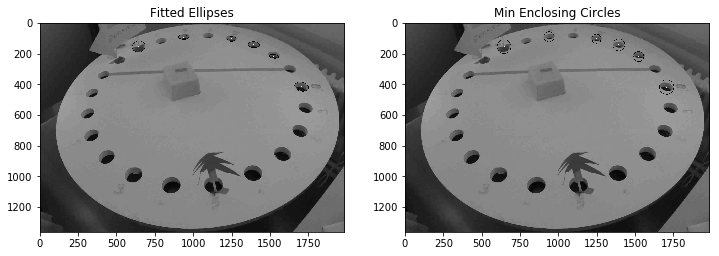

In [140]:
# Go back, take the corresponding contours and fit minimum enclosing circles
roiVis2 = gray.copy()
for i, ellip in enumerate (ellipList) :
    cont = ellip[3]
    c, r = cv2.minEnclosingCircle(cont)
    # print((np.int(c[0]), np.int(c[1])), np.int(r))
    cv2.circle(roiVis2, center = (np.int(c[0]), np.int(c[1])), radius = np.int(r), color = (0,255,0), thickness = 2)
    cv2.circle(roiVis2, center = (np.int(c[0]), np.int(c[1])), radius = 2, color = (255,0,0), thickness = 2)
    
    
# Visualize
# cv2.imshow('detected circles',warpedVis)
# # Esc kills the window
# if cv2.waitKey(0) & 0xff == 27:
#     cv2.destroyAllWindows()

fig, ax = plt.subplots(1,2, figsize = (12, 12))
ax[0].imshow(roiVis, cmap = "gray")
ax[0].set_title("Fitted Ellipses")
ax[1].imshow(roiVis2, cmap = "gray")
ax[1].set_title("Min Enclosing Circles")
plt.show()